In [223]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import requests
from tqdm.auto import tqdm
import time

# prediction imports
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import ruptures as rpt

from scipy.stats import probplot

sns.set_style('whitegrid')

### 1. Data examination

In [2]:
data = pd.read_csv('../data/age_estimations.csv')
data.head(10)

,lemma_,count,pos,lemma,freq,pos_fr,number_of_meanings,etymology,age
0,salon@NOUN,31950,NOUN,salon,6.085083e-05,substantif,6,1550.0,470.0
1,humoriste@NOUN,2731,NOUN,humoriste,5.201365e-06,substantif,1,1578.0,442.0
2,caricaturiste@NOUN,983,NOUN,caricaturiste,1.872187e-06,substantif,1,1803.0,217.0
3,dessinateur@NOUN,9436,NOUN,dessinateur,1.797147e-05,substantif,2,1667.0,353.0
4,humoristique@ADJ,5340,ADJ,humoristique,1.017037e-05,adjectif,1,1801.0,219.0
5,organiser@VERB,107773,VERB,organiser,2.052606e-04,verbe,4,1510.0,510.0
6,humoriste@ADJ,185,ADJ,humoriste,3.523444e-07,adjectif,1,1578.0,442.0
7,comité@NOUN,70991,NOUN,comité,1.352069e-04,substantif,2,1652.0,368.0
8,mondial@ADJ,168240,ADJ,mondial,3.204239e-04,adjectif,1,1550.0,470.0
9,gus@NOUN,341,NOUN,gus,6.494565e-07,substantif,1,1954.0,66.0


In [306]:
# data where the year is 1850
data_1850 = data[data['etymology'] == 1850]
data_1850

,lemma_,count,pos,lemma,freq,pos_fr,number_of_meanings,etymology,age,rank
795,drainage@NOUN,2578,NOUN,drainage,4.909967e-06,substantif,1,1850.0,170.0,1652.0
993,détective@NOUN,2344,NOUN,détective,4.464299e-06,substantif,2,1850.0,170.0,1784.5
1212,terminal@NOUN,5469,NOUN,terminal,1.041606e-05,substantif,4,1850.0,170.0,901.0
1354,indonésien@ADJ,3632,ADJ,indonésien,6.917378e-06,adjectif,1,1850.0,170.0,1255.0
2178,douanier@ADJ,2366,ADJ,douanier,4.506199e-06,adjectif,1,1850.0,170.0,1776.0
2927,rush@NOUN,388,NOUN,rush,7.389710e-07,substantif,3,1850.0,170.0,5892.5
3353,full@NOUN,156,NOUN,full,2.971120e-07,substantif,2,1850.0,170.0,9008.0
3936,ferromagnétique@ADJ,350,ADJ,ferromagnétique,6.665975e-07,adjectif,2,1850.0,170.0,6231.5
4046,étiquetage@NOUN,656,NOUN,étiquetage,1.249394e-06,substantif,1,1850.0,170.0,4353.0
4307,drainer@VERB,2619,VERB,drainer,4.988054e-06,verbe,2,1850.0,170.0,1631.0


In [3]:
data['rank'] = data['count'].rank(ascending=False)

In [4]:
data.shape

(10635, 10)

In [439]:
# number of senses / number of words
data.shape[0] / data['number_of_meanings'].sum()

0.575393604934264

In [5]:
with open('../data/lemma_freq.pkl', 'rb') as f:
    lemma_freq = pickle.load(f)

# remove elements with count < 1000
lemma_freq_ = {k: v for k, v in lemma_freq.items() if v['count'] > 100}

# get all the lemmas that have same pos as in data['pos']
lemma_freq_ = {k: v for k, v in lemma_freq_.items() if v['pos'] in data['pos'].unique()}

# share of lemmas that appeared after the 1500s 
data.shape[0] / len(lemma_freq_)

0.18219039624483924

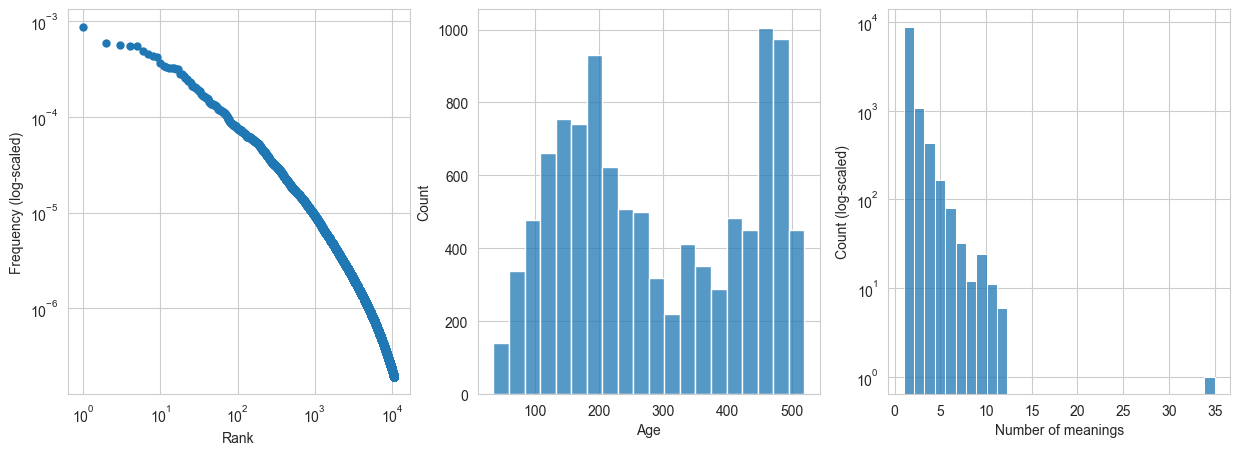

In [12]:
# plot distribuion of frequency, age, number of meanings in data on the same plot with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# first axis should be rank-frequency plot from data['count']
sns.scatterplot(x='rank', y='freq', data=data, ax=ax[0], linewidth = 0)
sns.histplot(data['age'], stat='count', ax=ax[1])
sns.histplot(data['number_of_meanings'], stat='count', ax=ax[2], bins=30)
# log scales in axes 0 and 2
# 1 axis should be log-log
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[2].set_yscale('log')
# ax[2].set_xlim(1)
# remove y axis labels for axes 1 and 2
ax[0].set_ylabel('Frequency (log-scaled)')
ax[1].set_ylabel('Count')
ax[2].set_ylabel('Count (log-scaled)')
ax[0].set_xlabel('Rank')
ax[1].set_xlabel('Age')
ax[2].set_xlabel('Number of meanings')
plt.show()

### 2. Get frequencies from n-gram

In [206]:
def get_ngram(query, start_year=1800, end_year=2019, 
            corpus='fr-2019'):
    time.sleep(np.random.uniform(0, 2))
    url = f'https://books.google.com/ngrams/json?content={query}&year_start={start_year}&year_end={end_year}&corpus={corpus}&smoothing=0'
    response = requests.get(url)
    data = response.json() 
    return data[0]['timeseries'] if data else None

In [207]:
data_1800 = data[data['etymology'] > 1800]
data_1800.shape

(4372, 10)

In [208]:
# sample 100 lemmas from data_1800
# lemma_sample = data_1800.sample(1000, random_state=42)

In [307]:
# get ngram frequencies for each word and save them in a long format with columns word, year, freq, etymology

freq = []
for i, row in tqdm(data_1800.iterrows(), total=data_1800.shape[0]):
    word = row['lemma']
    etymology = row['etymology']
    pos = row['pos']
    try:
        ngram = get_ngram(f'{word}_{pos}')
        if ngram:
            for i, freq_ in enumerate(ngram):
                freq.append([word, i, freq_, etymology])
    except:
        pass

df1800_freq = pd.DataFrame(freq, columns=['word', 'year', 'freq', 'etymology'])

  0%|          | 0/4372 [00:00<?, ?it/s]

In [308]:
df1800_freq['freq_scaled'] = df1800_freq.groupby('word')['freq'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
# convert df so that each word appears only once and has a column where the frequency time-series is stored as numpy array
df1800_freq_ = df1800_freq.groupby('word')['freq_scaled'].apply(list).reset_index()
df1800_freq_['freq_scaled'] = df1800_freq_['freq_scaled'].apply(lambda x: np.array(x))
df1800_freq_['etymology'] = df1800_freq.groupby('word')['etymology'].apply(list).reset_index()['etymology'].apply(lambda x: x[0])

In [347]:
# only keep if freq_scaled shape is 220,
# if not, remove
df1800_freq_['freq_scaled_len'] = df1800_freq_['freq_scaled'].apply(lambda x: x.shape[0])
df1800_freq_ = df1800_freq_[df1800_freq_['freq_scaled_len'] == 220]

In [348]:
df1800_freq_.shape

(4025, 4)

In [349]:
df1800_freq_.to_csv('../data/df1800_freq_.csv', index=False)

### 3. Change point prediction

In [377]:
class ChangePointRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, penalty=0.2, model="rbf", jump=2):
        self.penalty = penalty
        self.model = model
        self.jump = jump

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        result = []

        for time_series in X:
            # add jump
            algo = rpt.Pelt(model=self.model).fit(time_series)
            change_point = algo.predict(pen=self.penalty)[0]
            result.append(change_point)

        return np.array(result)

    def get_params(self, deep=True):
        return {"penalty": self.penalty, "model": self.model, "jump": self.jump}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


In [378]:
def prepare_data(df):
    max_length = max(len(seq) for seq in df['freq_scaled'])
    X = np.zeros((len(df), max_length))

    for i, seq in enumerate(df['freq_scaled']):
        X[i, :len(seq)] = seq

    y = np.array(df['etymology'])
    y = abs(1800 - y)
    return X, y

In [379]:
X, y = prepare_data(df1800_freq_)

In [380]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [381]:
X_train.shape

(3220, 220)

In [412]:
# use GridSearchCV to find the best penalty value for the classifier and the best model ('rbf', 'l1, 'l2')
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': np.linspace(0, 1, 10), 'model': ['rbf', 'l1', 'l2'], 'jump': np.arange(2, 20, 5)}

clf = GridSearchCV(ChangePointRegressor(), 
                   param_grid, 
                   cv=5, 
                   scoring='explained_variance', 
                   n_jobs=-1, 
                   verbose=10)

In [413]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[CV 4/5; 1/120] START jump=2, model=rbf, penalty=0.0............................
[CV 3/5; 2/120] START jump=2, model=rbf, penalty=0.1111111111111111.............
[CV 3/5; 1/120] START jump=2, model=rbf, penalty=0.0............................
[CV 1/5; 2/120] START jump=2, model=rbf, penalty=0.1111111111111111.............
[CV 1/5; 1/120] START jump=2, model=rbf, penalty=0.0............................
[CV 2/5; 1/120] START jump=2, model=rbf, penalty=0.0............................
[CV 2/5; 2/120] START jump=2, model=rbf, penalty=0.1111111111111111.............
[CV 5/5; 1/120] START jump=2, model=rbf, penalty=0.0............................
[CV 4/5; 1/120] END jump=2, model=rbf, penalty=0.0;, score=0.000 total time=   1.0s
[CV 3/5; 1/120] END jump=2, model=rbf, penalty=0.0;, score=-0.000 total time=   1.0s
[CV 4/5; 2/120] START jump=2, model=rbf, penalty=0.1111111111111111.............
[CV 5/5; 2/120] START jump=2, model=rbf, penalty=0.1111111111111111.............
[CV 1/5; 1/120] END j

GridSearchCV(cv=5, estimator=ChangePointRegressor(), n_jobs=-1,
             param_grid={'jump': array([ 2,  7, 12, 17]),
                         'model': ['rbf', 'l1', 'l2'],
                         'penalty': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             scoring='explained_variance', verbose=10)

In [414]:
clf.best_params_

{'jump': 2, 'model': 'l1', 'penalty': 0.1111111111111111}

In [415]:
clf.best_score_

0.4105271214396901

In [416]:
# pass clf.best_params_ to ChangePointRegressor and fit it on the whole dataset
model = ChangePointRegressor(**clf.best_params_)
model.fit(X_test, y_test)

# plot predicted vs true
y_pred = model.predict(X_test)

<AxesSubplot: >

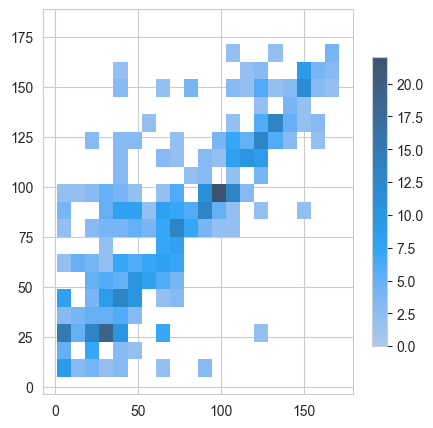

In [417]:
plt.figure(figsize=(5, 5))
sns.histplot(x = y_test, 
             y = y_pred, 
             bins=20, 
             cbar=True, 
             cbar_kws=dict(shrink=.75),
             thresh=1)

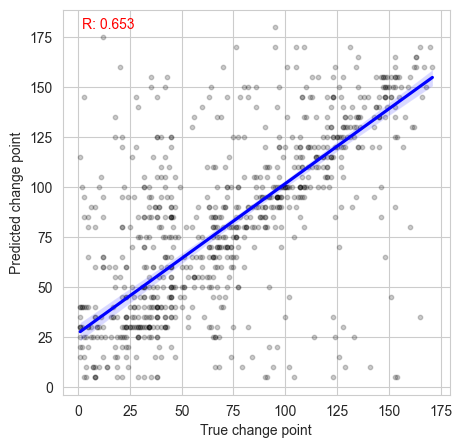

In [418]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.2, color='black', s=10)
# add a regplot
sns.regplot(x=y_test, y=y_pred, scatter=False, color='blue', robust=True)
plt.xlabel('True change point')
plt.ylabel('Predicted change point')
# add the amount of explained variance in top left corner
plt.text(0.05, 0.95, f'R: {np.corrcoef(y_test, y_pred)[0, 1]:.3f}', 
         transform=plt.gca().transAxes, color='red')
plt.show()

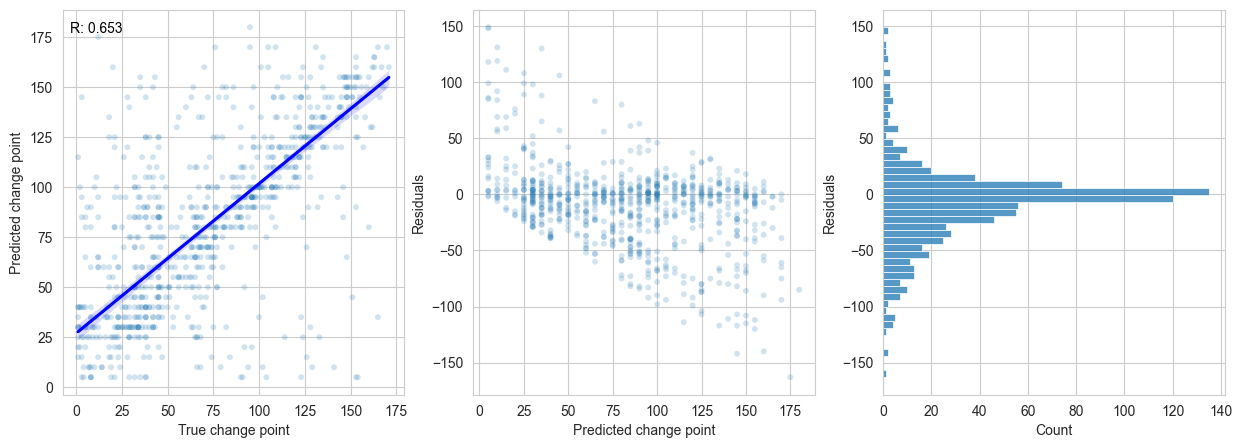

In [441]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=y_test, y=y_pred, alpha=0.2, ax=ax[0], size=5,
                legend=False, linewidth = 0)
sns.regplot(x=y_test, y=y_pred, scatter=False, color='blue', robust=True, ax=ax[0])
ax[0].set_xlabel('True change point')
ax[0].set_ylabel('Predicted change point')
ax[0].text(0.1, 0.95, f'R: {np.corrcoef(y_test, y_pred)[0, 1]:.3f}', 
           transform=ax[0].transAxes, color='black',
           ha='center', va='center', fontsize=10)

sns.scatterplot(x=y_pred, y=y_test - y_pred, 
                s=20, ax=ax[1], linewidth = 0, 
                alpha=0.2, size=5,
                legend=False,)
ax[1].set_xlabel('Predicted change point')
ax[1].set_ylabel('Residuals')

sns.histplot(y = y_test - y_pred, bins=50, ax=ax[2])
ax[2].set_ylabel('Residuals')
ax[2].set_xlabel('Count')

plt.show()
# save to pdf
fig.savefig('../figures/age_estimations.pdf', bbox_inches='tight')